In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Этапы
- удаление дубликатов
- работа с пропусками (удаление/заполнение)
- преобразование данных
- работа с выбросами
- очистка

In [2]:
df_orig = pd.read_csv('hh_ru_dataset.csv')

In [3]:
df = df_orig.copy()

In [4]:
df.shape

(500000, 26)

## Дупликаты

In [5]:
df[df.duplicated()].shape
# Out: (0, 26)
## Нет дубликатов

(0, 26)

In [6]:
df.topic_id.unique().shape
# Out: (499949,)
## Значит какие то уникальные идентификаторы повторяются (интересно)

(499949,)

In [7]:
## Уникальные ID, которые повторяются:
df[df.topic_id.map(df.topic_id.value_counts() > 1)].drop_duplicates(subset=['topic_id']).shape
# Out: (51, 26)
## Такие ID, для которых value_count > 1:
df[df.topic_id.map(df.topic_id.value_counts() > 1)].sort_values(by='topic_id')
# Out: (102, 26)

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,work_experience_months,resume_skills_list,vacancy_id,vacancy_creation_date,vacancy_region,work_schedule.1,vacancy_employment_type,compensation_from,compensation_to,vacancy_skills_list
492749,3304126c969696,2023-06-15 00:00:00.000,response,response,202048kbb,2023-06-07 00:00:00.000,"Директор магазина, директор сети магазинов",male,1999,Омская область,...,40,"['ответственность', 'поиск и привлечение клиен...",81tb8tb6,2023-06-15 00:00:00.000,Тверская область,flexible,full,46600.0,NaN,[None]
90108,3304126c969696,2023-06-15 00:00:00.000,response,discard,b265k25,2008-03-05 00:00:00.000,Бухгалтер,female,1973,Москва,...,290,"['оптимизация затрат', '1c: бухгалтерия', 'фин...",81564tbb,2023-06-05 00:00:00.000,Москва,full_day,full,200000.0,0.0,"['контур-экстерн', '1c: финансы']"
452364,330964699696,2023-06-19 00:00:00.000,response,invitation,1b08tkb85,2020-02-26 00:00:00.000,"Директор магазина, директор сети магазинов",female,1985,Свердловская область,...,103,"['уверенное знание пк', 'коммуникабельность', ...",81605666,2023-06-06 00:00:00.000,Свердловская область,full_day,full,47000.0,0.0,"['многозадачность', 'умение работать в режиме ..."
409935,330964699696,2023-06-19 00:00:00.000,response,response,18615b14k,2022-07-21 00:00:00.000,Юрисконсульт,male,1981,Москва,...,202,"['английский язык', 'арбитражные суды', 'гаран...",8gb2b01,2023-06-19 00:00:00.000,Москва,full_day,full,100000.0,0.0,"['электронная почта', 'microsoft powerpoint', ..."
67858,33096969641269,2023-06-20 00:00:00.000,response,invitation,1t0024bkt,2022-10-04 00:00:00.000,Специалист по подбору персонала,female,1997,Самарская область,...,20,"['исполнительность', 'подбор персонала', 'масс...",8208b2g,2023-06-18 00:00:00.000,Самарская область,remote,full,NaN,70000.0,[None]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10868,b079691c96,2023-08-23 00:00:00.000,response,response,2456t655,2013-04-16 00:00:00.000,"Менеджер по продажам, менеджер по работе с кли...",female,1988,Москва,...,166,"['ответственность', 'холодные продажи', 'работ...",84tbtb06,2023-08-11 00:00:00.000,Москва,full_day,full,150000.0,NaN,"['работа с большим объемом информации', 'телеф..."
418788,b096963390,2023-08-24 00:00:00.000,response,response,14kkkk001,2021-03-21 00:00:00.000,"Фитнес-тренер, инструктор тренажерного зала",male,1995,Москва,...,72,"['детский пауэрлифтинг', 'исполнительность', '...",8455046k,2023-08-04 00:00:00.000,Москва,shift,part,25000.0,80000.0,[None]
286691,b096963390,2023-08-24 00:00:00.000,response,response,16042b81b,2022-01-08 00:00:00.000,"Фитнес-тренер, инструктор тренажерного зала",female,1996,Москва,...,40,"['кмс по художественной гимнастике', 'награжде...",84t62001,2023-08-11 00:00:00.000,Москва,shift,full,60000.0,80000.0,"['материальная ответственность', 'работа в ком..."
131075,b096c4412967,2023-08-24 00:00:00.000,response,response,k48818t4,2015-09-16 00:00:00.000,Менеджер по закупкам,male,1970,Московская область,...,301,"['1с: торговля и склад', 'ms word', 'my sap er...",84511141,2023-08-03 00:00:00.000,Москва,full_day,full,120000.0,NaN,"['подготовка коммерческих предложений', 'анали..."


## Пропуски

In [8]:
df.isnull().sum()

topic_id                        0
topic_creation_date             0
initial_state                 834
final_state                   834
resume_id                       0
resume_creation_date            0
profession                      0
gender                          0
year_of_birth                   0
resume_region                   0
education_level               102
expected_salary             10786
relocation_status               0
business_trip_readiness         0
work_schedule                6911
resume_employment_type          0
work_experience_months          0
resume_skills_list          37448
vacancy_id                      0
vacancy_creation_date           0
vacancy_region                  0
work_schedule.1                 0
vacancy_employment_type         0
compensation_from           29382
compensation_to            138225
vacancy_skills_list             0
dtype: int64

Удаляем *nan* в ***initial_state*** и ***final_state***, так как неизвестны причина и итог взаимодействия

In [9]:
df = df.dropna(subset=['initial_state', 'final_state'])

В строке ***education_level*** отсутствуют некторые значения, разберёмся, почему.

In [10]:
df.education_level.unique()

array(['higher', 'unfinished_higher', 'special_secondary', 'secondary',
       'bachelor', 'master', 'candidate', nan, 'doctor'], dtype=object)

При создании резюме [*hh.ru*](hh.ru) предлагает выбрать уровень образования. В списке уровни расположены по возрастанию.

Без указания уровня образования создать резюме не выйдет. Вывод - ошибки при записи данных, тем более таких 102 строки

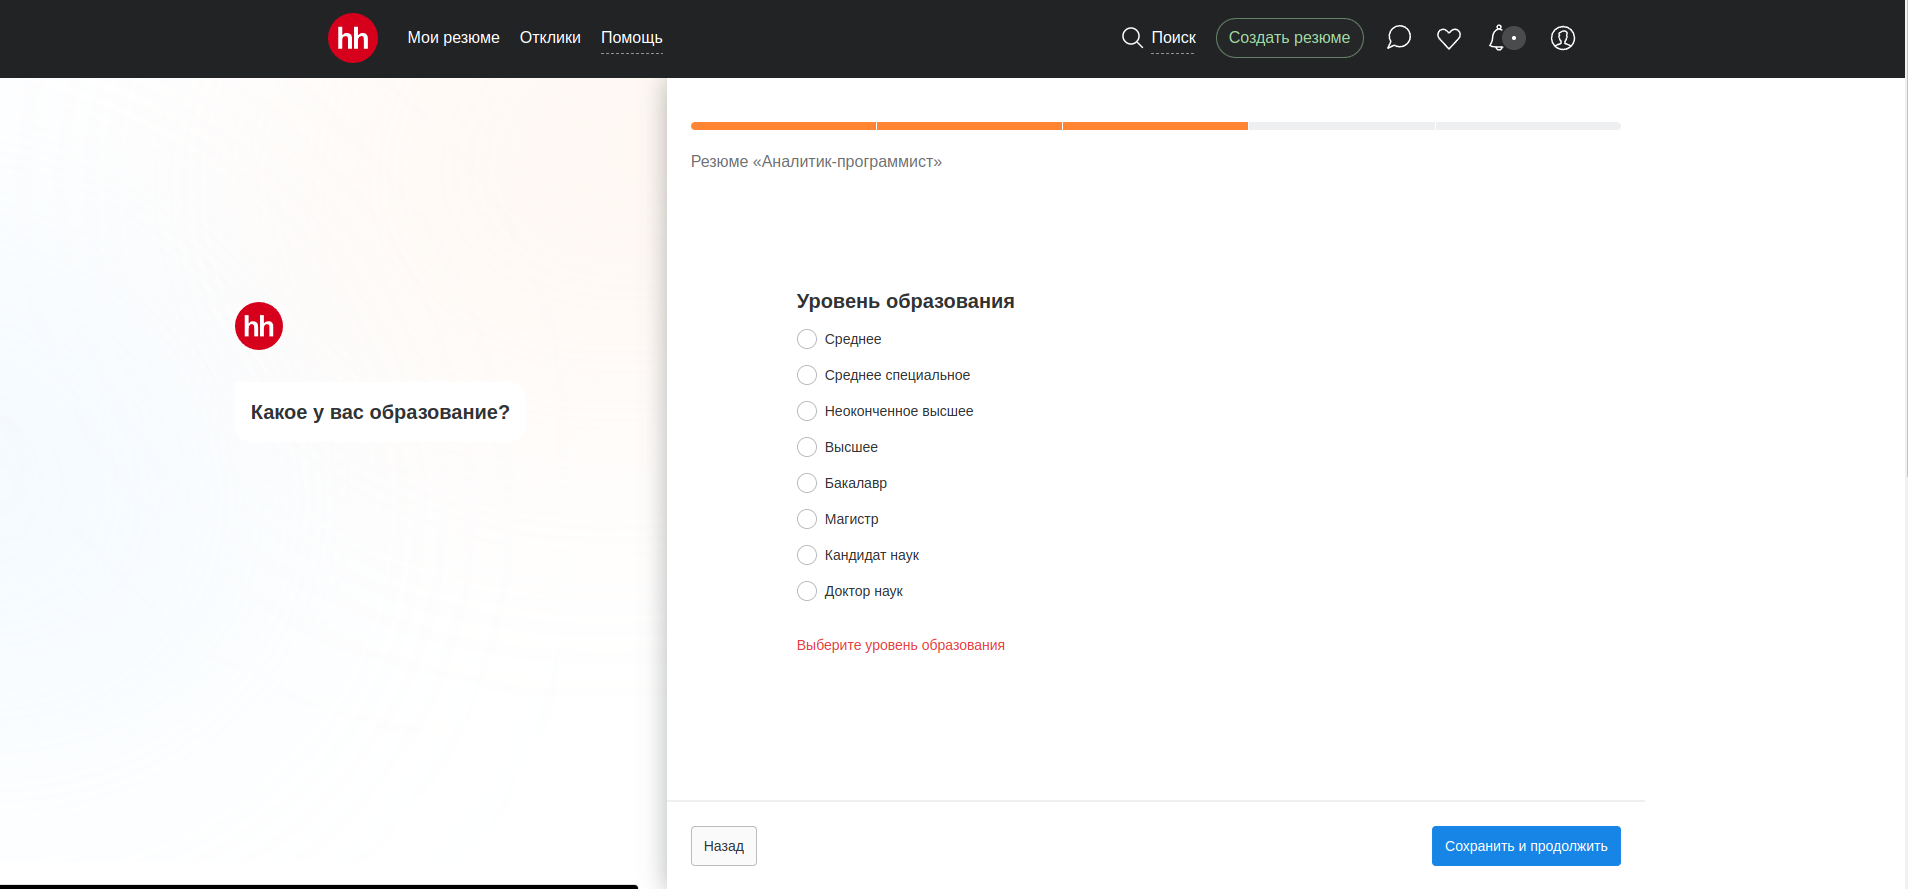

In [11]:
df = df.dropna(subset=['education_level'])

In [12]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499064 entries, 0 to 499063
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   topic_id                 499064 non-null  object 
 1   topic_creation_date      499064 non-null  object 
 2   initial_state            499064 non-null  object 
 3   final_state              499064 non-null  object 
 4   resume_id                499064 non-null  object 
 5   resume_creation_date     499064 non-null  object 
 6   profession               499064 non-null  object 
 7   gender                   499064 non-null  object 
 8   year_of_birth            499064 non-null  int64  
 9   resume_region            499064 non-null  object 
 10  education_level          499064 non-null  object 
 11  expected_salary          488311 non-null  float64
 12  relocation_status        499064 non-null  object 
 13  business_trip_readiness  499064 non-null  object 
 14  work

## Преобразование

In [13]:
df['applicant_age'] = 0
# создадим переменную возраста соискателя
# а именно это возраст, который будет у соискателя к концу 2023 года - погрешность 12 месяцев
for index, row in df.iterrows():
    birth_year = row['year_of_birth']
    df.loc[index, 'applicant_age'] = 2023 - int(birth_year)

In [14]:
# число месяцев обучения после 11 класса
education_dict = {
    'secondary': 0,
    'special_secondary': 24,
    'unfinished_higher': 12,        
    'bachelor': 48,
    'master': 72,
    'higher': 60,
    'candidate': 108,
    'doctor': 144
}
df['study_months'] = 0
df['successful_topic'] =  0
for index, row in df.iterrows():
    if (row['initial_state'] == 'invitation') or (row['final_state'] == 'invitation'):
        df.loc[index, 'successful_topic'] = 1
    if row['applicant_age'] == 14 or row['applicant_age'] == 15 or row['applicant_age'] == 16:
        df.loc[index, 'study_months'] = 0
    else:
        df.loc[index, 'study_months'] = education_dict[row['education_level']]

In [15]:
df = df.rename(columns={'work_schedule.1': 'work_schedule_required'})

## Выбросы

In [16]:
# проверяем временной промежуток для topic_creation_date
dates = df.topic_creation_date.unique().tolist()
years = set()
months = set()
days = set()
for elem in dates:
    years.add(elem[0:4])
    months.add(elem[5:7])
    days.add(elem[8:10])
print(sorted(years))
print(sorted(months))
print(sorted(days))
# всё норм
# resume_creation_date и vacancy_creation_date проверять не нужно
# резюме и вакансии могли быть созданы и раньше

['2023']
['06', '07', '08']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [17]:
print(f'Min age: {df.applicant_age.min()}')
print(f'Max age: {df.applicant_age.max()}')
df[df.applicant_age < 19].applicant_age.value_counts()

Min age: 14
Max age: 123


applicant_age
18    7286
17    4915
16    3269
15    1367
14     608
Name: count, dtype: int64

<Axes: ylabel='applicant_age'>

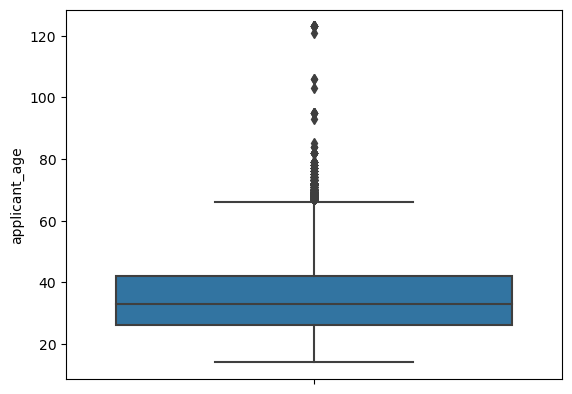

In [18]:
sns.boxplot(df, y='applicant_age')

In [19]:
# при трудоустройстве пенсионера опыт работы и число месяцев обучения не являются решающимми факторам для работодателя
# df = df[df.applicant_age <= 74]
# удалили 147

In [20]:
# 53 удалим просто и всё
# df = df[df.education_level != 'doctor']
# df.shape

In [21]:
# Волонтеры нам не нужны...
df = df[(df.vacancy_employment_type != 'volonteer') | (df.resume_employment_type != 'volonteer')]
df.shape

(499064, 29)

In [22]:
df['max_possible_experience'] = (df['applicant_age'] - 14) * 12
df['diff_in_exp'] = df['max_possible_experience'] - df['work_experience_months']
df['outlier'] = 'Нет'
for index, row in df.iterrows():
    if row['diff_in_exp'] < -12:
        df.loc[index, 'outlier'] = 'Да'

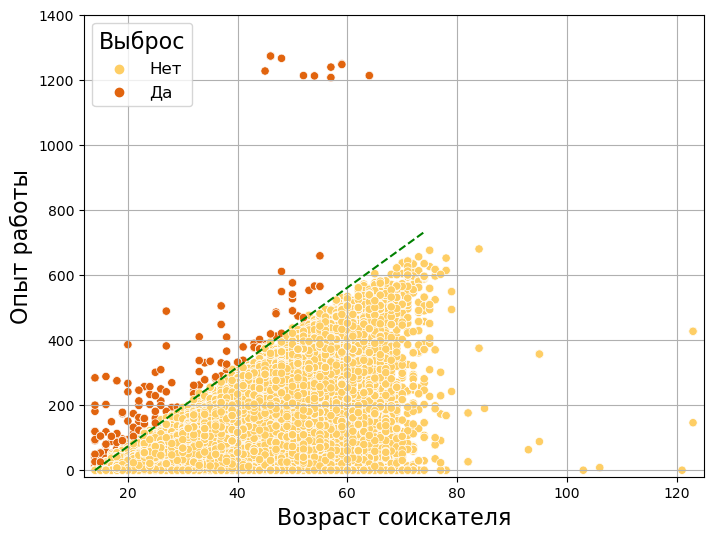

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='applicant_age', y='work_experience_months', hue='outlier', palette='YlOrBr')
plt.xlim(df.applicant_age.min() - 2, df.applicant_age.max() + 2)
plt.ylim(-20, 1400)
plt.xlabel('Возраст соискателя', fontsize=16)
plt.ylabel('Опыт работы', fontsize=16)
plt.legend(title='Выброс', fontsize=12, title_fontsize=16, loc='upper left')
plt.plot(np.array([14, 74]), [0, 732], color='green', ls='--')
plt.grid()

In [24]:
df[df.outlier == 'Да'].shape

(318, 32)

In [25]:
df = df[df.outlier == 'Нет']

<Axes: ylabel='diff_in_exp'>

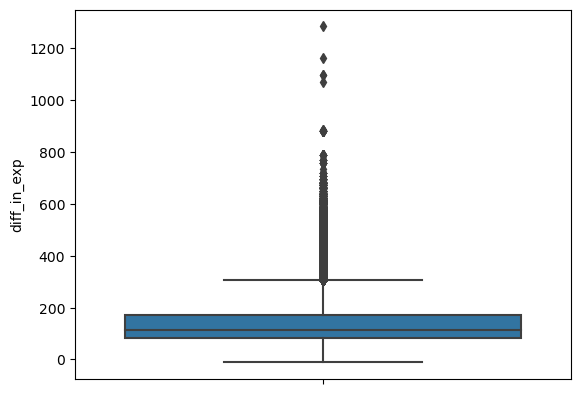

In [26]:
sns.boxplot(df, y='diff_in_exp')

In [27]:
df['diff_in_edu'] = (df.applicant_age - 17) * 12 - df.study_months
for index, row in df.iterrows():
    if row['applicant_age'] in [14, 15, 16]:
        continue
    if row['diff_in_edu'] < -12:
        df.loc[index, 'outlier'] = 'Да'

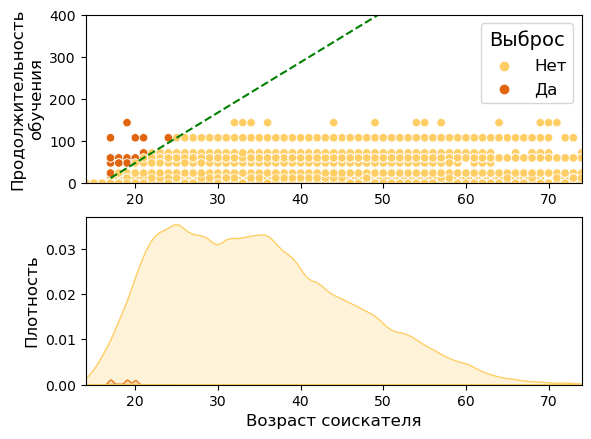

In [28]:
fig, axes = plt.subplots(2, 1)
a = sns.scatterplot(df, x='applicant_age', y='study_months', hue='outlier', palette='YlOrBr', ax=axes[0])
axes[0].plot([17, 74], [12, 696], color='green', ls='--')
b = sns.kdeplot(df, x='applicant_age', hue='outlier', palette='YlOrBr', ax=axes[1], fill=True)
axes[0].set_ylabel('Продолжительность\nобучения', fontsize=12)
axes[0].set_xlabel('')
axes[1].set_xlabel('Возраст соискателя', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[0].set_ylim(0, 400)
axes[0].set_xlim(14, 74)
axes[1].set_xlim(14, 74)
handles, labels = a.get_legend_handles_labels()
a.get_legend().remove()
b.get_legend().remove()
a.legend(handles, labels, title='Выброс', fontsize=12, title_fontsize=14)
plt.show()

In [29]:
df = df[df.outlier != 'Да']

In [30]:
print(f'Удалено {round(100 - df.shape[0]/df_orig.shape[0]*100, 2)}% строк ({df_orig.shape[0] - df.shape[0]} строк)')
print(f'Осталось для анализа {df.shape[0]} строк')

Удалено 0.52% строк (2577 строк)
Осталось для анализа 497423 строк


# Сохранение

In [31]:
df.columns

Index(['topic_id', 'topic_creation_date', 'initial_state', 'final_state',
       'resume_id', 'resume_creation_date', 'profession', 'gender',
       'year_of_birth', 'resume_region', 'education_level', 'expected_salary',
       'relocation_status', 'business_trip_readiness', 'work_schedule',
       'resume_employment_type', 'work_experience_months',
       'resume_skills_list', 'vacancy_id', 'vacancy_creation_date',
       'vacancy_region', 'work_schedule_required', 'vacancy_employment_type',
       'compensation_from', 'compensation_to', 'vacancy_skills_list',
       'applicant_age', 'study_months', 'successful_topic',
       'max_possible_experience', 'diff_in_exp', 'outlier', 'diff_in_edu'],
      dtype='object')

In [32]:
# Удаляем ненужные или вспомогаттельные столбцы
df = df.drop(columns=[
    'topic_id', 'topic_creation_date', 'initial_state', 'final_state', 'resume_creation_date',
    'year_of_birth', 'resume_region', 'education_level', 'expected_salary',
    'relocation_status', 'business_trip_readiness', 'work_schedule',
    'resume_employment_type', 'resume_skills_list', 'vacancy_id', 'vacancy_creation_date',
    'work_schedule_required', 'vacancy_employment_type', 'compensation_from', 'compensation_to', 'vacancy_skills_list',
    'max_possible_experience', 'diff_in_exp', 'diff_in_edu', 'outlier'
])

In [33]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497423 entries, 0 to 497422
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   resume_id               497423 non-null  object
 1   profession              497423 non-null  object
 2   gender                  497423 non-null  object
 3   work_experience_months  497423 non-null  int64 
 4   vacancy_region          497423 non-null  object
 5   applicant_age           497423 non-null  int64 
 6   study_months            497423 non-null  int64 
 7   successful_topic        497423 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 30.4+ MB


In [34]:
df.to_csv('processed-hh-ru-all-age.csv', index=False)
df[df.applicant_age <= 74].to_csv('processed-hh-ru-74.csv', index=False)

In [35]:
df.describe()

,work_experience_months,applicant_age,study_months,successful_topic
count,497423.000000,497423.000000,497423.000000,497423.000000
mean,108.067407,34.721933,38.924931,0.369301
std,95.771043,11.105435,24.168589,0.482616
min,0.000000,14.000000,0.000000,0.000000
25%,32.000000,26.000000,24.000000,0.000000
50%,85.000000,33.000000,48.000000,0.000000
75%,160.000000,42.000000,60.000000,1.000000
max,680.000000,123.000000,144.000000,1.000000


In [36]:
df[df.applicant_age <= 74].describe()

,work_experience_months,applicant_age,study_months,successful_topic
count,497275.000000,497275.000000,497275.000000,497275.000000
mean,108.011541,34.707594,38.919938,0.369351
std,95.657163,11.073441,24.167109,0.482630
min,0.000000,14.000000,0.000000,0.000000
25%,32.000000,26.000000,24.000000,0.000000
50%,85.000000,33.000000,48.000000,0.000000
75%,160.000000,42.000000,60.000000,1.000000
max,656.000000,74.000000,144.000000,1.000000
